# Precipitation timeseries



In [45]:
import glob
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd

def extract_file_info(d):
    
    #Mapping between levels
    level_dict = {'L1': 'El Nino Static SST. ablco2=6',
                  'L2': 'EC Earth SST. ablco2=6',
                  'L3': 'El Nino Static SST. ablco2=21',
                  'L4': 'EC Earth SST. ablco2=21'
                  }
    dir_name = d.split('/')[-2]
    #print(dir_name)
    #Create some useful labels
    #print(d.split('/'))

    label = dir_name.split('/')[-1]
    level = label.split('_')[1]
    prec = label.split('_')[2]
    rounding = label.split('_')[3]
    title = level_dict[level]
    
    keys = ['label', 'level', 'precision','title']
    values = [label,level,prec+'_'+rounding,title]
    dictionary = {keys[i]: values[i] for i in range(len(keys))}
    
    return dictionary

def average_over_space(x,weights):
        return x.weighted(weights).mean(("longitude", "latitude"))#.data #Get the average global precipitation at each timestep.
        #return x.mean(("longitude", "latitude"))


def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude




def process_nc_file(f,true_latitude):
    
    #Open dataset
    ds = xr.open_dataset(f)
    
    
    #Reset the latitude
    ds = ds.assign_coords(latitude=(true_latitude))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
    
    #Define weights
    weights = np.cos(np.deg2rad(true_latitude))
    weights.name = "weights"
    
    #Get precipitations
    LSP = ds.large_scale_precipitation * (6*60*60) / 1000 #mm / 6h
    CVP = ds.convective_precipitation  * (6*60*60) / 1000 #mm / 6h              

    
    if LSP.shape == (365, 48, 96):
        use = True
    else:
        use = False

        
    #Average
    LSP_av = average_over_space(LSP,weights)
    CVP_av = average_over_space(CVP,weights)
    precipitation = LSP_av + CVP_av #* (6*60*60) / 1000 #mm / 6h
    
    data_dictionary = {'time': LSP.forecast_period,
                       'precip': precipitation}
    df_out = pd.DataFrame(data_dictionary)
    
    
    #Get meta information
    f_info = extract_file_info(f)
    index = df_out.index
    df_info = pd.DataFrame(f_info,index=index)

    #Create pandas df and append
    df_meta = pd.concat([df_out,df_info,],axis=1) 
    
    #Get annual average
    df_average_annual = df_meta.groupby(['precision']).mean()
    
    return df_average_annual.reset_index(),use
    
             
        
    
def process_directory(d,true_latitude):


    print ('Directory',d)
    nc_files = sorted(glob.glob(d+'/**/*model_output*.nc',recursive=True))

    dfs = [] # df of solution level i
    counter = 0
    #for n in tqdm(nc_files):
    for n in nc_files:
        print (n)
        df_year,use = process_nc_file(n,true_latitude)
        if use:
            dfs.append(df_year)

    df = pd.concat(dfs,ignore_index=True)
    df['X'] = np.arange(len(df))

 
    return df



def process_node(node,fname):
    
    print ('--------------------------')
    print ('Processing', node, fname)

    #Parameters
    root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'
    
    #Get the global weights
    true_lat = get_global_weights()
    

        
    precision_directories = glob.glob(root+node+'*')
    dfs = []
    for precision in precision_directories:
    
    
        df = process_directory(precision,true_lat)
        dfs.append(df)
        


    print ('Saving')
    #save it
    df = pd.concat(dfs)
    pd.to_pickle(df,fname)
    
    return df
        
        
        
        
        
        
        

In [46]:
node = 'paper/100year/tmp_m8/'
fname = 'small_data/m8_precipthrowaway_weighted.pkl'
df8 = process_node(node,fname)

--------------------------
Processing paper/100year/tmp_m8/ small_data/m8_precipthrowaway_weighted.pkl
Directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00001.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00002.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00003.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00004.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00005.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00006.n

In [19]:
# #m5
node = 'paper/100year/tmp_m5/'
fname = 'small_data/m5_precip.pkl'
#df5 = process_node(node,fname)

#m6
node = 'paper/100year/tmp_m6/'
fname = 'small_data/m6_precip.pkl'
#df6 = process_node(node,fname)

#m7
node = 'paper/100year/tmp_m7/'
fname = 'small_data/m7_precip_test.pkl'
df7 = process_node(node,fname)

#m8
node = 'paper/100year/tmp_m8/'
fname = 'small_data/m8_precip.pkl'
#df8 = process_node(node,fname)




--------------------------
Processing paper/100year/tmp_m7/ small_data/m7_precip_test.pkl
Directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00001.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00002.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00003.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00004.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00005.nc
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00006.nc
/network/gr

# Process all ensemble members

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
def calculate_residuals(df):
    
    
    #Get a ground truth that all others will be compared against. i.e. 52 RNe
    df_truth = df.query('precision == "52_RN" ')[['X', 'precip']]
    df_truth['merge_column'] = df_truth['X'].astype(int) #Create a column to merge on.     #Note integer conversions are needed for join

    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #reset index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    #Get residual
    df_join['MBE'] = df_join['precip'] - df_join['preciptruth']
    df_join['MAE'] = abs(df_join['precip'] - df_join['preciptruth'])
    
    print ('Average:')
    display(df_join.groupby(by=["precision"]).mean()) 
    display(len(df_join))
    return df_join

def plot_timeseries(df,time_period,title,savefig):
    
    #Take an average over time_period number of days. Set time_period = 365 for yearly average
   # df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
   # df_averaged['years'] =  df_averaged['X'] / 365 #Convert from days to years
    
    #Get the residuals of the averaged df
    df_residuals = calculate_residuals(df)
   # 
    #Setup plot configuration
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))

   
    
    
    #Plot the timeseries
    p = sns.lineplot(data=df, x="X", y='precip', hue="precision",ax=ax1,style='precision',markers=True)
    
    #Plot the residuals
    q = sns.lineplot(data=df_residuals, x="X", y='MBE', hue="precision",ax=ax2,style='precision',markers=True,legend=True)

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Global Mean Surface Temperature (K)")
    ax2.set_ylabel("Mean Bias Error(K)")

    
    ax2.set_xlabel("Time (years)")
    ax2.axhline(0.0, c='0.5', linestyle='--')
    #ax2.set_yscale('log')
    
    #ax1.set_ylim(288,292.5)
    ax1.set_title(None)
    
    
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    #Other config
    ax1.legend().set_title(None)
    
    
    

small_data/m5_precip.pkl
Average:


,index,precip,X,merge_column,Xtruth,preciptruth,MBE,MAE
precision,,,,,,,,
10_RN,49.5,0.521704,49.5,49.5,49.5,0.531256,-0.009553,0.009799
10_SR,49.5,0.530780,49.5,49.5,49.5,0.531256,-0.000476,0.004336
23_RN,49.5,0.530113,49.5,49.5,49.5,0.531256,-0.001143,0.003676


300

small_data/m8_precipthrowaway_unweighted.pkl
Average:


,index,precip,X,merge_column,Xtruth,preciptruth,MBE,MAE
precision,,,,,,,,
10_RN,49.5,0.655773,49.5,49.5,49.5,0.666496,-0.010723,0.010856
10_SR,49.5,0.666608,49.5,49.5,49.5,0.666496,0.000113,0.003017
23_RN,49.5,0.666520,49.5,49.5,49.5,0.666496,0.000024,0.002458


300

small_data/m8_precipthrowaway_weighted.pkl
Average:


,index,precip,X,merge_column,Xtruth,preciptruth,MBE,MAE
precision,,,,,,,,
10_RN,49.5,0.762022,49.5,49.5,49.5,0.773698,-0.011675,0.011893
10_SR,49.5,0.773616,49.5,49.5,49.5,0.773698,-0.000081,0.003607
23_RN,49.5,0.773750,49.5,49.5,49.5,0.773698,0.000053,0.003230


300

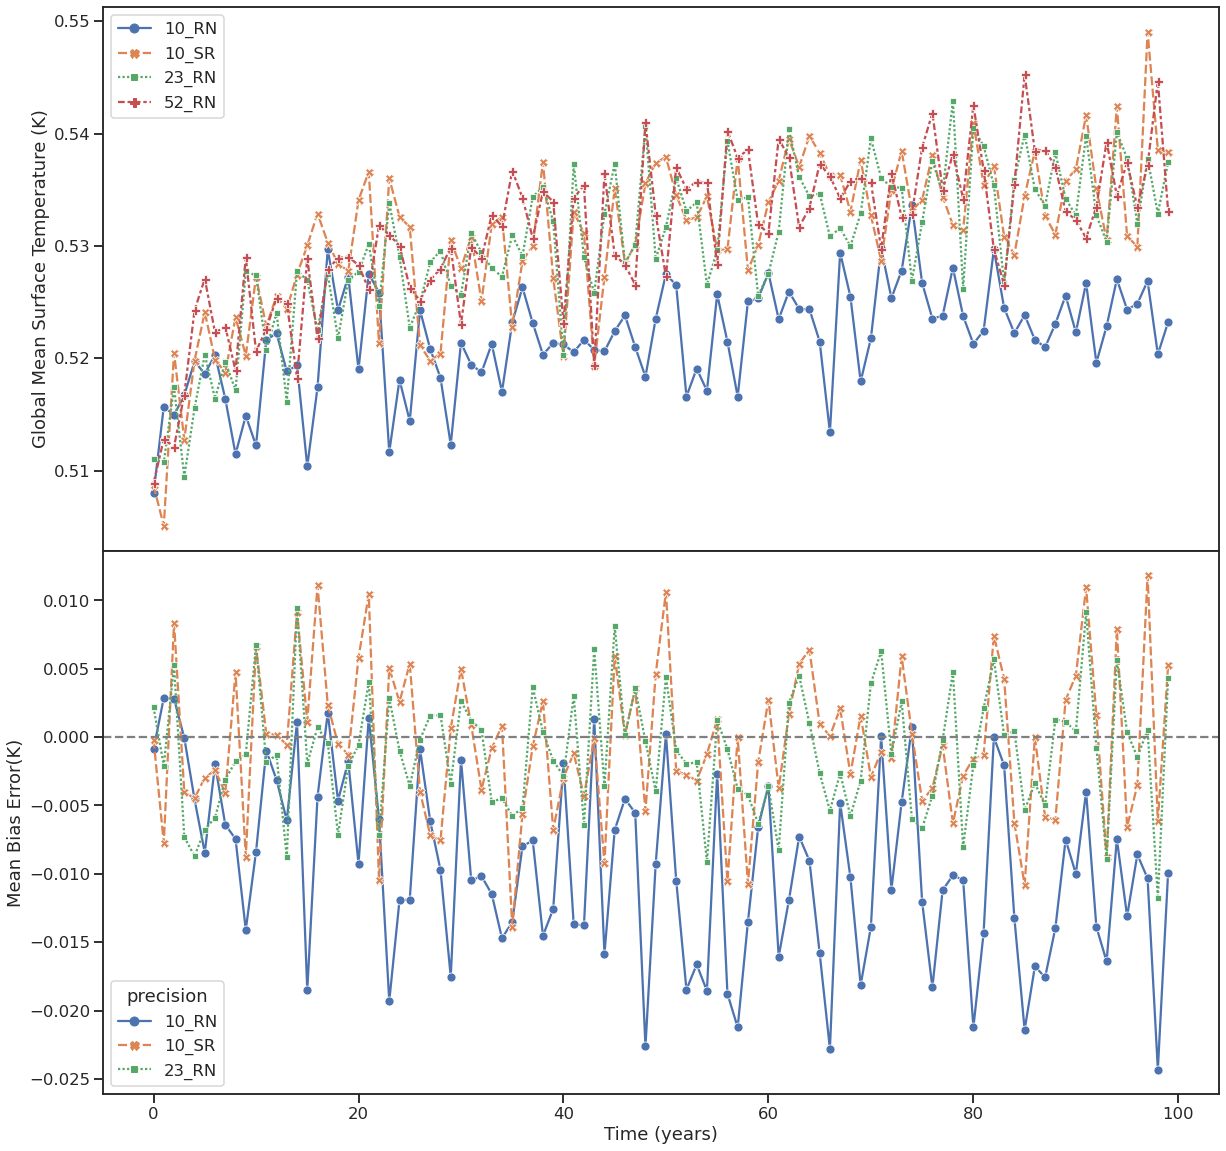

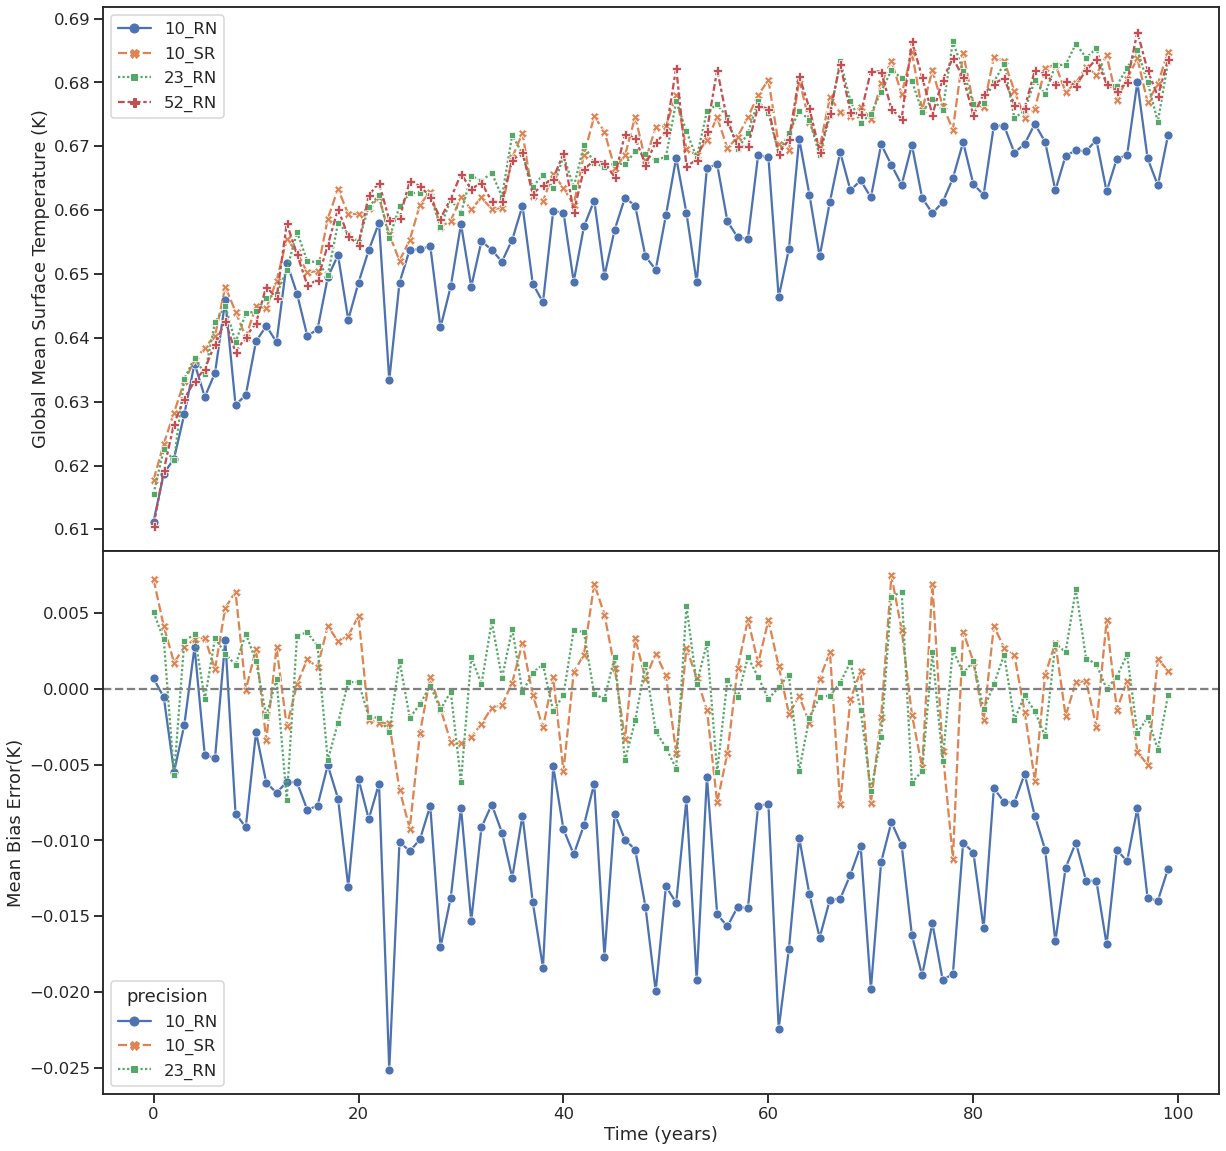

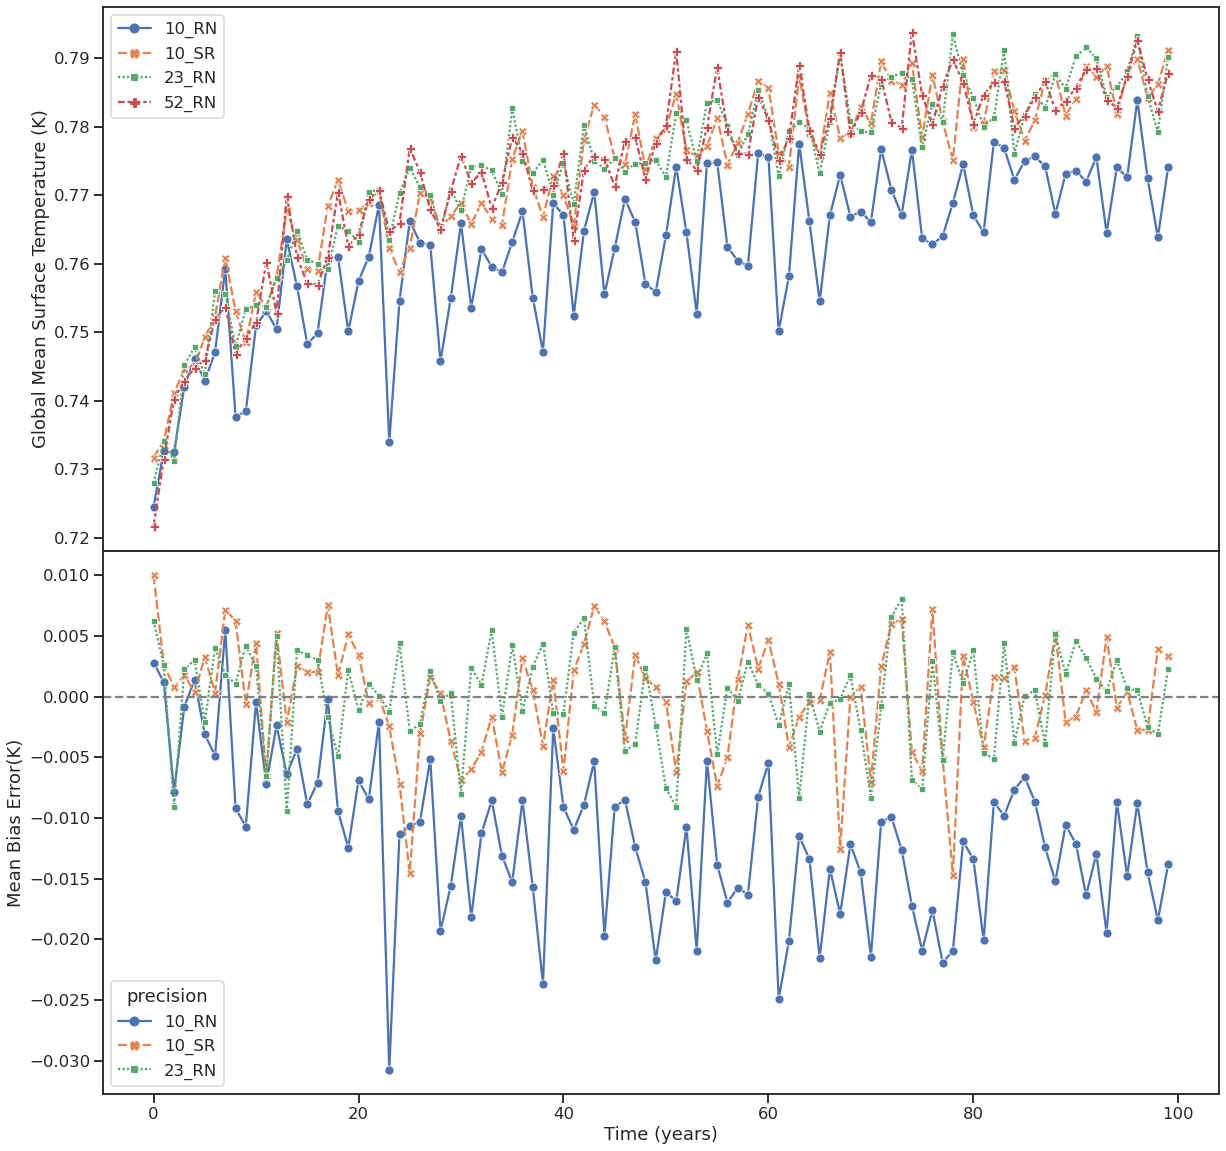

In [49]:
#for m in ['m5_example_precip.pkl']: #,'m6_example.pkl','m7_example.pkl']:
#for m in sorted(glob.glob('small_data/m*precip.pkl')):
#for m in ['small_data/m7_precip_test.pkl','small_data/m7_precip.pkl']:
for m in ['small_data/m5_precip.pkl','small_data/m8_precipthrowaway_unweighted.pkl','small_data/m8_precipthrowaway_weighted.pkl']:
    print(m)
    dtmp = pd.read_pickle(m)
    #display(dtmp)
    plot_timeseries(dtmp.reset_index().sort_values(by=['precision']),time_period=365,title=m,savefig=None)

small_data/m8_precipthrowaway_unweighted.pkl
Average:


,index,precip,X,merge_column,Xtruth,preciptruth,MBE,MAE
precision,,,,,,,,
10_RN,49.5,0.655773,49.5,49.5,49.5,0.666496,-0.010723,0.010856
10_SR,49.5,0.666608,49.5,49.5,49.5,0.666496,0.000113,0.003017
23_RN,49.5,0.666520,49.5,49.5,49.5,0.666496,0.000024,0.002458


300

small_data/m8_precip.pkl
Average:


,index,precip,X,merge_column,Xtruth,preciptruth,MBE,MAE
precision,,,,,,,,
10_RN,49.5,0.762022,49.5,49.5,49.5,0.773698,-0.011675,0.011893
10_SR,49.5,0.773616,49.5,49.5,49.5,0.773698,-0.000081,0.003607
23_RN,49.5,0.773750,49.5,49.5,49.5,0.773698,0.000053,0.003230


300

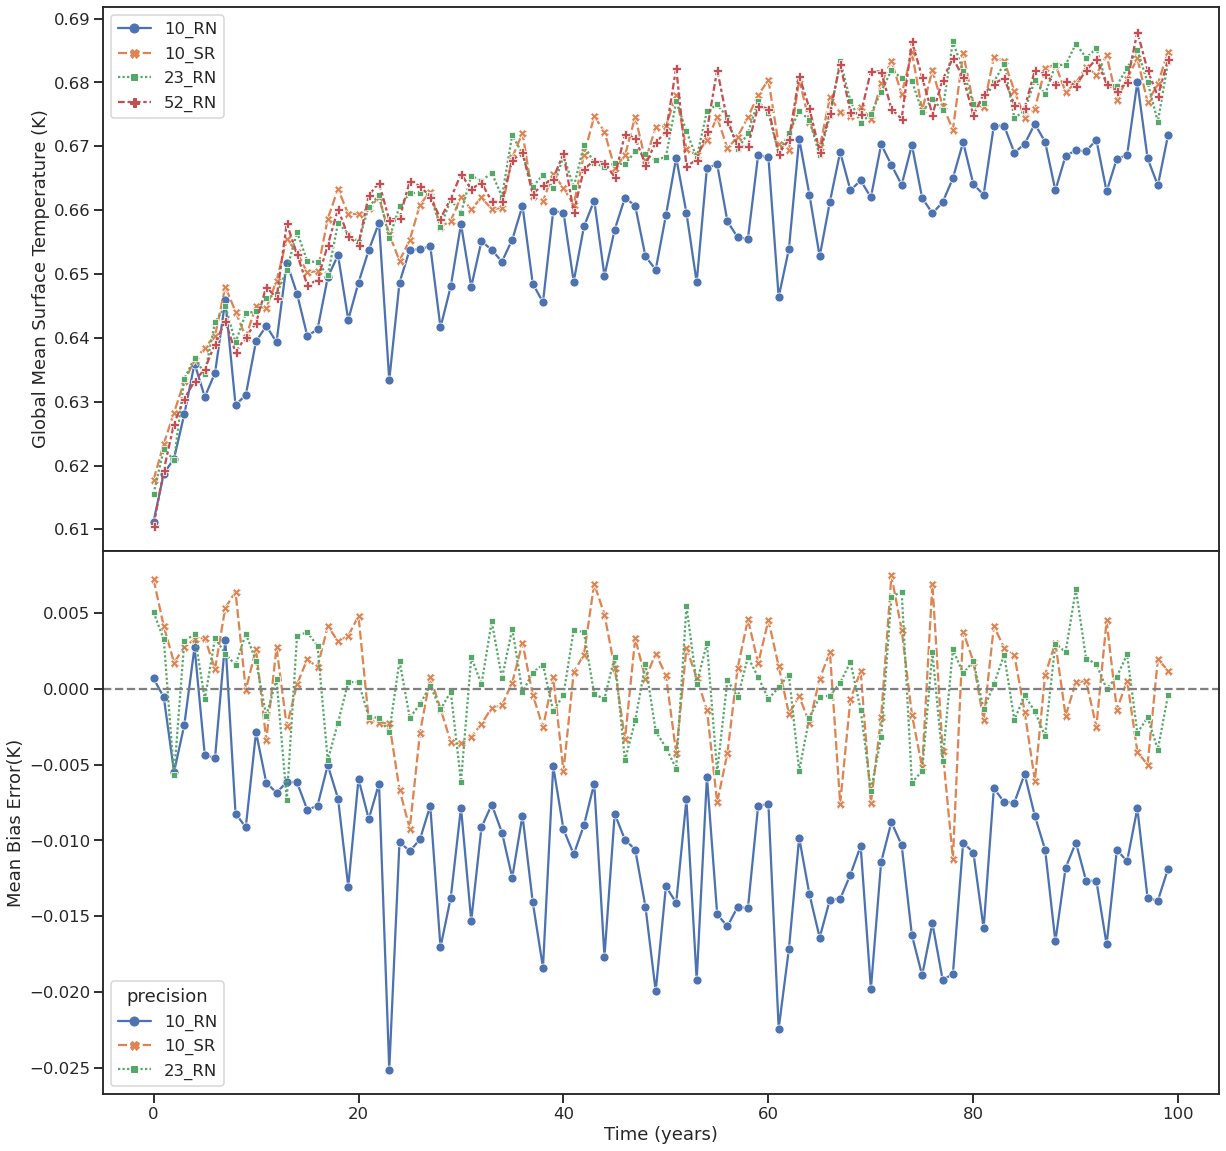

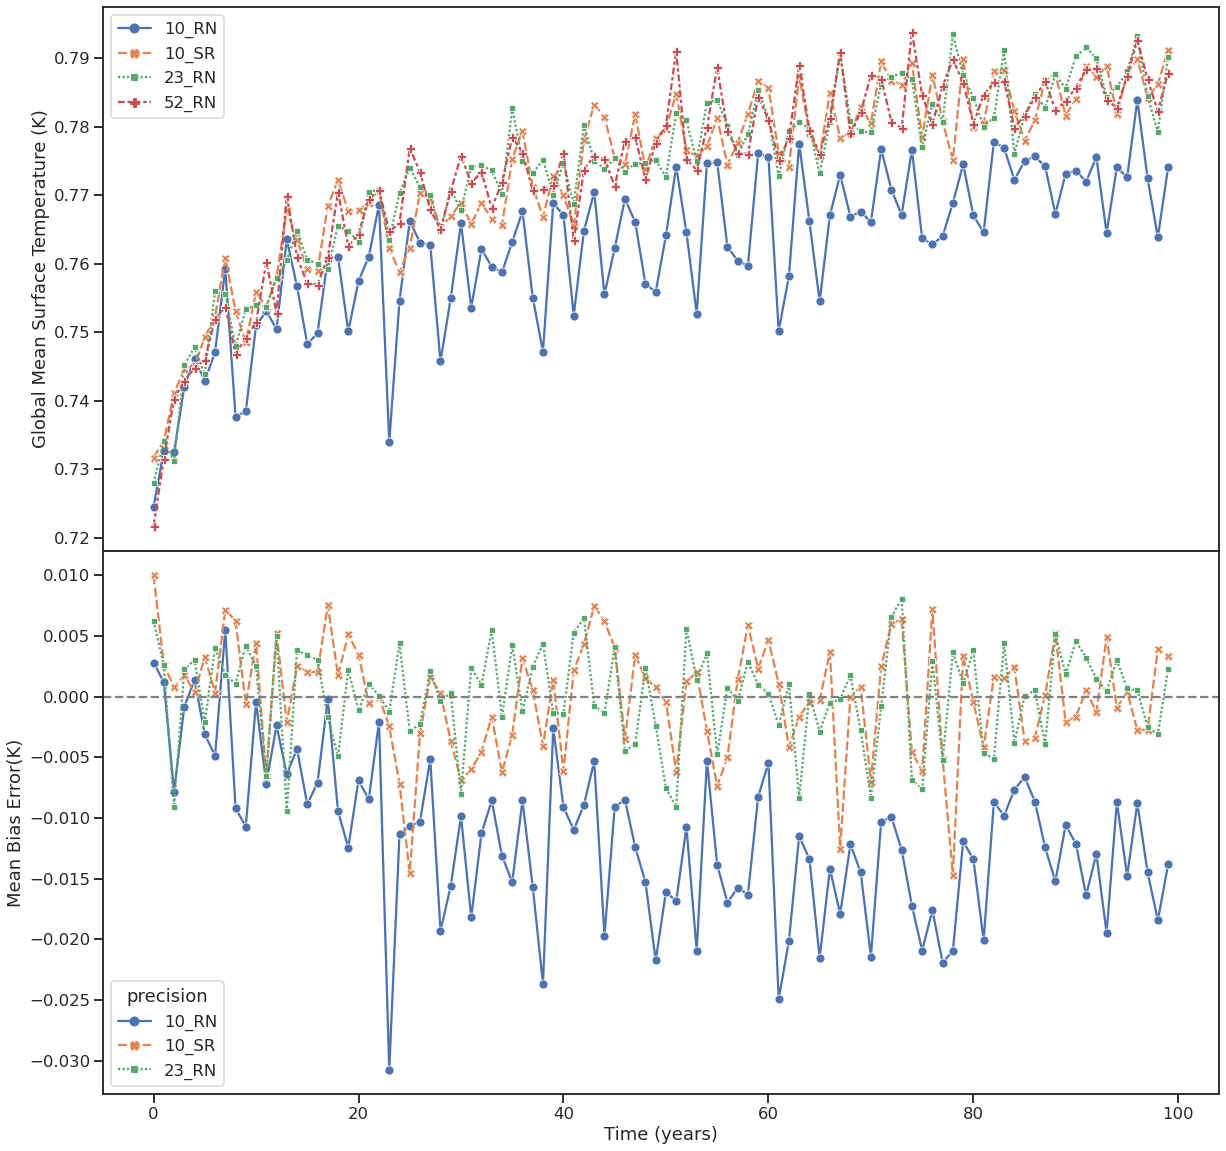

In [42]:
#for m in ['m5_example_precip.pkl']: #,'m6_example.pkl','m7_example.pkl']:
#for m in sorted(glob.glob('small_data/m*precip.pkl')):
#for m in ['small_data/m7_precip_test.pkl','small_data/m7_precip.pkl']:
for m in ['small_data/m8_precipthrowaway_unweighted.pkl','small_data/m8_precip.pkl']:
    print(m)
    dtmp = pd.read_pickle(m)
    #display(dtmp)
    plot_timeseries(dtmp.reset_index().sort_values(by=['precision']),time_period=365,title=m,savefig=None)

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_config(ax1,ax2,save):
    

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Gloabl Mean Surface Temperature (K)")#, fontsize = 20)
    ax2.set_ylabel("Absolute Error (K)")#, fontsize = 20)


    ax2.set_xlabel("Time (years)")#, fontsize = 20)
    ax2.axhline(0.0, c='0.5', linestyle='--')
    

   # ax1.set_xlim(0,400)
    ax1.set_ylim(288,292.5)

    #Other config
    ax1.legend().set_title(None)
    
    if save:
        plt.savefig('figs/Fig1_Williams.png', dpi=300, bbox_inches='tight')


    
    
def get_relative_error_df(df):
    
    
    #Get a ground truth that all others will be compared against
    df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
    df_truth['merge_column'] = df_truth['X'].astype(int)
    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #rest index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    
    #Note integer conversions are needed for join

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    
    #Get the absolute error
    #df_join['error']  = df_join['temperature'] - df_join['temperaturetruth']
    df_join['error']  = abs(df_join['temperature'] - df_join['temperaturetruth'])/df_join['temperaturetruth']

    
    return df_join
    
def plot_error_timeseries(df1,df2,save_it):
    
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    

    
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    df1['years'] = df1.X/365
    
    
    #Plot the df directly
    p = sns.lineplot(data=df1, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)


    #Calculate the relative_error df and plot
    df_error = get_relative_error_df(df1)
    #df_error['years'] = df2.X #/365

    df_error['years'] = df_error['X']/365
    
    decadal_window = 1 #take an average over N years
    df_error_decadal = df_error.groupby([df_error.years//decadal_window, 'label','level','precision', 'title'],as_index=False).mean()
    p = sns.lineplot(data=df_error_decadal, x="years", y='error', hue="precision",ax=ax2,style='precision',markers=True,legend=None)


    plot_config(ax1,ax2,save_it)

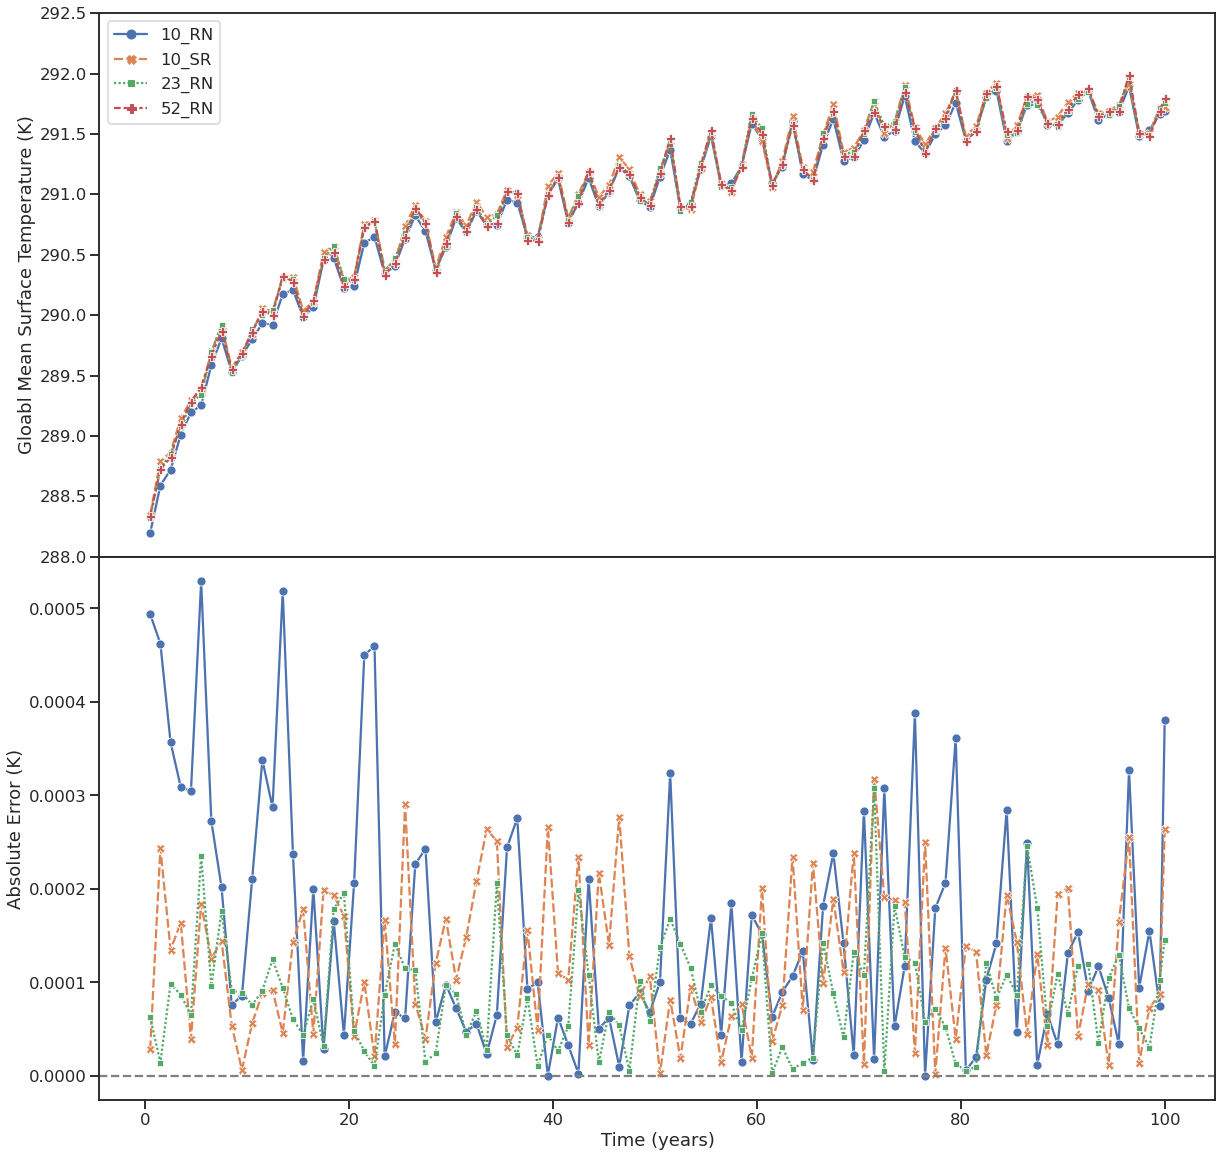

In [19]:
save_it = True #Do you want to save the Fig?
plot_error_timeseries(df_annual_mean,df_decadal_mean,save_it)

In [23]:
df_decadal_mean['years'] = df_decadal_mean.X/365 

In [21]:
df_error = get_relative_error_df(df_annual_mean)
